In [1]:
from keras.layers import *
import tensorflow.keras.backend as K
import numpy as np
from keras import optimizers, Model
from keras.utils import Sequence
from numpy.random import seed
import math
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
import time
from keras.callbacks import TensorBoard
from utils import *

2024-09-01 13:27:21.342261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-01 13:27:21.342288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-01 13:27:21.343269: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-01 13:27:21.348224: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-01 13:27:21.852478: W tensorflow/compiler/tf2

In [2]:
# Build Channel Attention Block
def eca_block(tensor, b=1, gama=8):
    init = tensor
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[channel_axis]
    eca_shape = (1,filters)
    init1 = Reshape(target_shape=(eca_shape))(init)   
    in_channel=1
    
    kernel_size = int(abs((math.log(in_channel, 2) + b) / gama))
    
    if kernel_size % 2:
        kernel_size = kernel_size
    
    else:
        kernel_size = kernel_size + 1
    
    x = GlobalAveragePooling1D()(init1)
    x = Reshape(eca_shape)(x)

    x = Conv1D(filters=1, kernel_size=kernel_size, padding='same', use_bias=False)(x) 
    print('k size 1:', kernel_size)
    x = tf.nn.relu(x)
    x = Conv1D(filters=1, kernel_size=kernel_size, padding='same', use_bias=False)(x)  
    print('k size 2:', kernel_size)
    x = tf.nn.sigmoid(x)    
    x = Reshape((1,1,in_channel))(x)
    #x = GlobalAveragePooling1D()(x)
    
    outputs = multiply([init1, x])
    outputs = tf.keras.backend.squeeze(outputs,1)
    # outputs = GlobalAveragePooling1D()(outputs)
    return outputs


def remove_columns_kurtosis(matrix, alpha):
    from scipy.stats import kurtosis
    kurtosis = kurtosis(matrix, axis=1)
    
    threshold = np.percentile(kurtosis, alpha*100)
    
    selected_columns = kurtosis > threshold

    return matrix[selected_columns, :]

def inception_res(input_tensor):
    e0 = input_tensor

    e1 = Conv1D(1, 1, padding='same')(e0)
    e1 = Conv1D(1, 3, padding='same', activation='tanh')(e1)
    e1 = Conv1D(1, 3, padding='same', activation='tanh')(e1)
    e1 = BatchNormalization()(e1)
    
    e2 = Conv1D(1, 1, padding='same')(e0)
    e2 = Conv1D(1, 3, padding='same', activation='tanh')(e2)
    e2 = BatchNormalization()(e2)

    e3 = Conv1D(1, 1, padding='same')(e0)
    e3 = BatchNormalization()(e3)
    
    con = Concatenate()([e1, e2, e3])
    con = Conv1D(1, 1, padding='same')(con)

    con_1 = Add()([con, e0])
    # out_tensor = tf.nn.relu(con_1)

    return(con_1)

def mff_block(input_tensor, filters, kernel_size, strides):
    e1 = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(input_tensor)
    e1 = BatchNormalization()(e1)
    e1 = PReLU()(e1)

    e2 = Conv1D(filters=filters, kernel_size=kernel_size+3, strides=strides+2, padding='same')(input_tensor)
    e2 = BatchNormalization()(e2)
    e2 = PReLU()(e2)

    con_e = concatenate([e2, e1], axis=-1)
    out_con = Conv1D(1, 1, activation='tanh')(con_e)
    out_con = Add()([out_con, input_tensor])
    # outputs = tf.nn.relu(out_con)

    return out_con

In [3]:
# Load Data and Patches
w1=48
w2=48
z1=6
z2=6
batch = 1024
drop_rate = 0.25

file_path = '/home/g202321530/Yang/Project/DAS_coupling/Data/raw/Germen/'
file_name = 'slice_german'


data = np.load(f'{file_path}{file_name}.npy')
data = data[:, :650]

print(data.shape)
# plt.imshow(data, cmap='seismic', vmin=-20, vmax=20)
dataNoise = yc_patch(data, w1, w2, z1, z2)
dataNoise1 = remove_columns_kurtosis(dataNoise, drop_rate)
print(dataNoise.shape, dataNoise1.shape)
INPUT_SIZE1 = dataNoise.shape[0]
INPUT_SIZE2 = dataNoise.shape[1]
input_img = Input(shape=(INPUT_SIZE2,))
print(INPUT_SIZE2,"INPUTR_SIZE2")
input_img1 = input_img[:,:, tf.newaxis]
print(input_img1.shape)

(1800, 650)
(29886, 2304) (22414, 2304)
2304 INPUTR_SIZE2
(None, 2304, 1)


2024-09-01 13:27:23.788129: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-01 13:27:23.788349: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-01 13:27:23.818336: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# Building the DIP model.
D1 = 128
D2 = D1/4 #32
D3 = D2/4 #8
D4 = int(D3/2) #2
print(D1,D2,D3,D4)
k = 3
s = 3

input_img1 = input_img[:,tf.newaxis]
# Encoder
encoded1 = Conv1D(filters=D1, kernel_size=k, padding='same', name='e1')(input_img1)
encoded1 = BatchNormalization()(encoded1)
encoded1 = PReLU()(encoded1)
encoded1x = Conv1D(filters=D1, kernel_size=k+3, padding='same', name='e11')(input_img1)
#encoded1x = BatchNormalization()(encoded1x)
encoded1x = PReLU()(encoded1x)
encoded1x = concatenate([encoded1x, encoded1], axis=-1)
encoded1x = Dense(D1)(encoded1x)
encoded1x = PReLU()(encoded1x)


skip1 = eca_block(encoded1x)


encoded2 = Conv1D(filters=D2, kernel_size=k, padding='same', name='e2')(encoded1x)
encoded2 = BatchNormalization()(encoded2)
encoded2 = PReLU()(encoded2)
encoded2x = Conv1D(filters=D2, kernel_size=k+3, padding='same', name='e22')(encoded1x)
#encoded2x = BatchNormalization()(encoded2x)
encoded2x = PReLU()(encoded2x)
encoded2x = concatenate([encoded2x, encoded2], axis=-1)
encoded2x = Dense(D2)(encoded2x)
encoded2x = PReLU()(encoded2x)


skip2 = eca_block(encoded2x)


encoded3 = Conv1D(filters=D3, kernel_size=k, padding='same', name='e3')(encoded2x)
encoded3 = BatchNormalization()(encoded3)
encoded3 = PReLU()(encoded3)
encoded3x = Conv1D(filters=D3, kernel_size=k+3, padding='same', name='e33')(encoded2x)
#encoded3x = BatchNormalization()(encoded3x)
encoded3x = PReLU()(encoded3x)
encoded3x = concatenate([encoded3x, encoded3], axis=-1)
encoded3x = Dense(D3)(encoded3x)
encoded3x = PReLU()(encoded3x)

skip3 = eca_block(encoded3x)

# # Decoder
decoded3 = Conv1D(filters=D3, kernel_size=k, padding='same', name='d3')(encoded3x)
decoded3 = BatchNormalization()(decoded3)
decoded3 = PReLU()(decoded3)
decoded3x = Conv1D(filters=D3, kernel_size=k+3, padding='same', name='d33')(encoded3x)
#decoded3x = BatchNormalization()(decoded3x)
decoded3x = PReLU()(decoded3x)
decoded3x = concatenate([decoded3x, decoded3], axis=-1)
decoded3x = Dense(D3)(decoded3x)
decoded3x = PReLU()(decoded3x)


decoded3xx = concatenate([decoded3x, skip3])


decoded2 = Conv1D(filters=D2, kernel_size=k, padding='same', name='d2')(decoded3xx)
decoded2 = BatchNormalization()(decoded2)
decoded2 = PReLU()(decoded2)
decoded2x = Conv1D(filters=D2, kernel_size=k+3, padding='same', name='d22')(encoded2x)
#decoded2x = BatchNormalization()(decoded2x)
decoded2x = PReLU()(decoded2x)
decoded2x = concatenate([decoded2x, decoded2], axis=-1)
decoded2x = Dense(D2)(decoded2x)
decoded2x = PReLU()(decoded2x)


decoded2xx = concatenate([decoded2x, skip2])

decoded1 = Conv1D(filters=D1, kernel_size=k, padding='same', name='d1')(decoded2xx)
decoded1 = BatchNormalization()(decoded1)
decoded1 = PReLU()(decoded1)
decoded1x = Conv1D(filters=D1, kernel_size=k+3, padding='same', name='d11')(decoded2xx)
#decoded1x = BatchNormalization()(decoded1x)
decoded1x = PReLU()(decoded1x)
decoded1x = concatenate([decoded1x, decoded1], axis=-1)
decoded1x = Dense(D1)(decoded1x)
decoded1x = PReLU()(decoded1x)


decoded1xx = concatenate([decoded1x, skip1])


decoded1xx = Conv1D(INPUT_SIZE2/3, 1, 1, padding='same')(decoded1xx)
decoded = Conv1D(INPUT_SIZE2, 1, padding='same')(decoded1xx)
decoded = Flatten()(decoded)


autoencoder = Model(input_img, decoded)
optimizer = optimizers.Adam(lr=0.01)


autoencoder.compile(optimizer=optimizer, loss='MSE')
autoencoder.summary()

128 32.0 8.0 4
k size 1: 1
k size 2: 1
k size 1: 1
k size 2: 1
k size 1: 1
k size 2: 1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2304)]               0         []                            
                                                                                                  
 tf.__operators__.getitem_1  (None, 1, 2304)              0         ['input_1[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                                  
 e1 (Conv1D)                 (None, 1, 128)               884864    ['tf.__operators__.getitem_1[0
                                                                    ][0]']                        
                                                                                              

In [5]:
# Addig stopping condition
model_path = "/home/g202321530/Yang/Project/DAS_coupling/Data/model/German/"
es=EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
mc=ModelCheckpoint(f'{model_path}_model_{file_name}_p{w1}_s{z1}_drop_{drop_rate}.h5', monitor='loss', mode='min', save_best_only=True)


# Tic-Toc

batch=1024
epoch = 80
#tbCallBack = TensorBoard(log_dir="./model/best_model3.h5", histogram_freq=1,write_grads=True)
history = autoencoder.fit(dataNoise1, dataNoise1, verbose=1, epochs=epoch, batch_size=batch, shuffle=True, callbacks=[es, mc])

Epoch 1/80


2024-09-01 13:27:28.890363: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-09-01 13:27:30.188092: I external/local_xla/xla/service/service.cc:168] XLA service 0x70759fc67db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-01 13:27:30.188108: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4500, Compute Capability 8.6
2024-09-01 13:27:30.188114: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A4500, Compute Capability 8.6
2024-09-01 13:27:30.192160: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1725186450.249714 3125177 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 [==============================] - 14s 163ms/step - loss: 0.0039
Epoch 2/80


/home/g202321530/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 1s 27ms/step - loss: 0.0017
Epoch 3/80
22/22 [==============================] - 1s 27ms/step - loss: 0.0015
Epoch 4/80
22/22 [==============================] - 1s 26ms/step - loss: 0.0013
Epoch 5/80
22/22 [==============================] - 1s 26ms/step - loss: 0.0011
Epoch 6/80
22/22 [==============================] - 1s 27ms/step - loss: 0.0010
Epoch 7/80
22/22 [==============================] - 1s 25ms/step - loss: 9.3329e-04
Epoch 8/80
22/22 [==============================] - 1s 27ms/step - loss: 8.8614e-04
Epoch 9/80
22/22 [==============================] - 1s 29ms/step - loss: 8.5576e-04
Epoch 10/80
22/22 [==============================] - 1s 30ms/step - loss: 8.2854e-04
Epoch 11/80
22/22 [==============================] - 1s 30ms/step - loss: 8.0593e-04
Epoch 12/80
22/22 [==============================] - 1s 31ms/step - loss: 7.8863e-04
Epoch 13/80
22/22 [==============================] - 1s 31ms/step - loss: 7.7246e-04
Epoch 14/80
22/22 [

In [6]:
def localsimi(d1,d2,rect,niter=50,eps=0.0,verb=1):

	import numpy as np
	
	if d1.ndim==2:
		d1=np.expand_dims(d1, axis=2)
	if d2.ndim==2:
		d2=np.expand_dims(d2, axis=2)
	[n1,n2,n3]=d1.shape

	nd=n1*n2*n3;
	ndat=[n1,n2,n3];
	eps_dv=eps;
	eps_cg=0.1; 
	tol_cg=0.000001;

	ratio = divne(d2, d1, niter, rect, ndat, eps_dv, eps_cg, tol_cg,verb);
	ratio1 = divne(d1, d2, niter, rect, ndat, eps_dv, eps_cg, tol_cg,verb);
	simi=np.sqrt(np.abs(ratio*ratio1));
	return simi
 
def cseis():
    from matplotlib.colors import ListedColormap
    import numpy as np
    seis=np.concatenate(
(np.concatenate((0.5*np.ones([1,40]),np.expand_dims(np.linspace(0.5,1,88),axis=1).transpose(),np.expand_dims(np.linspace(1,0,88),axis=1).transpose(),np.zeros([1,40])),axis=1).transpose(),
np.concatenate((0.25*np.ones([1,40]),np.expand_dims(np.linspace(0.25,1,88),axis=1).transpose(),np.expand_dims(np.linspace(1,0,88),axis=1).transpose(),np.zeros([1,40])),axis=1).transpose(),
np.concatenate((np.zeros([1,40]),np.expand_dims(np.linspace(0,1,88),axis=1).transpose(),np.expand_dims(np.linspace(1,0,88),axis=1).transpose(),np.zeros([1,40])),axis=1).transpose()),axis=1)
    return ListedColormap(seis)

In [7]:
from keras.models import load_model
model = load_model(f'{model_path}_model_{file_name}_p{w1}_s{z1}_drop_{drop_rate}.h5')

In [8]:
# patching
data = np.load(f'{file_path}{file_name}.npy')
data = data[:, :650]
dataNoisy = yc_patch(data, w1, w2, z1, z2)
print(data.shape, dataNoisy.shape)

out_path = '/home/g202321530/Yang/Project/DAS_coupling/python_code/denoised_data/German/'
# predict
# T1 = time.perf_counter()
out = model.predict(dataNoisy)
# T2 = time.perf_counter() 
# print("Time cost:%s s" % (T2-T1))
out = np.transpose(out)
print(out.shape)
# unpatching
n1, n2 = data.shape
predicted = yc_patch_inv(out,n1,n2,w1,w2,z1,z2)
np.save(f'{out_path}{file_name}_p{w1}_s{z1}_drop_{drop_rate}_epoch{epoch}.npy', predicted)

(1800, 650) (29886, 2304)
934/934 [==============================] - 5s 5ms/step
(2304, 29886)


In [9]:
# calculate simi
noise = data-predicted
rect=[20,20,1];
eps=0;
niter=20;
verb=1;

#simi1=localsimi(predicted,noise,[5,5,1],niter,eps,verb);
#simi1 = np.squeeze(simi1)
#print(np.mean(simi1))

NameError: name 'simi1' is not defined

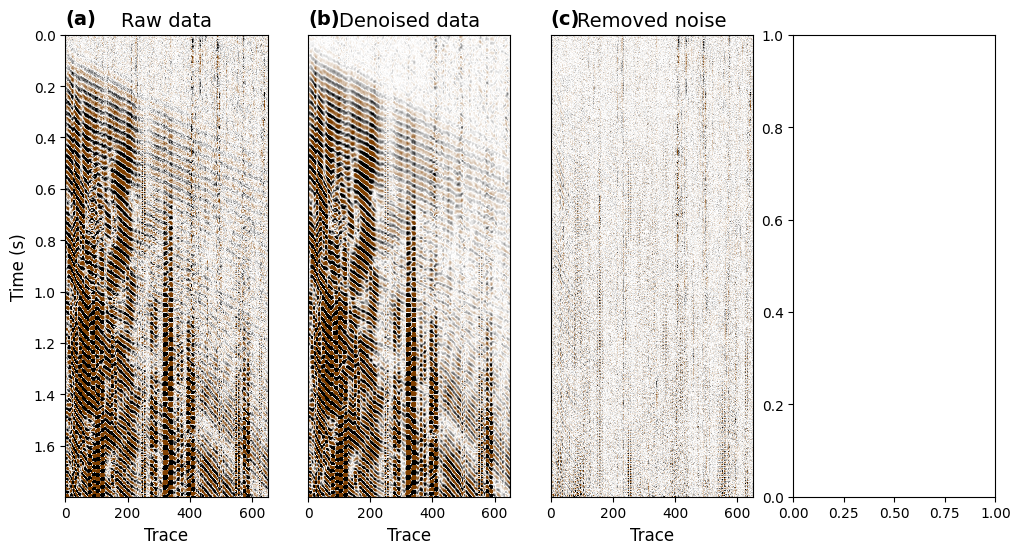

In [10]:
import matplotlib.pyplot as plt
v = 0.05
xx, yy = 0, 0.1
v1 = 1

num_samples = len(data[:, 1])
num_samples_x = len(data[1, :])
time_interval = 0.001
time = np.arange(0, num_samples) * time_interval
fig_path = '/home/g202321530/Yang/Project/DAS_coupling/python_code/denoised_fig/German/'

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,4,1)
plt.imshow(data,cmap=cseis(), vmin=-v, vmax=v, aspect='auto', extent=(0, num_samples_x, time[-1], 0));
plt.xlabel("Trace", fontsize=12)
plt.ylabel("Time (s)", fontsize=12)
plt.title('Raw data', fontsize=14);
plt.annotate('(a)', xy=(0, 0), xytext=(-xx, -yy), fontsize=14, fontweight='bold', va='top')

ax2 = fig.add_subplot(1,4,2)
plt.imshow(predicted,cmap=cseis(), vmin=-v, vmax=v, aspect='auto',  extent=(0, num_samples_x, time[-1], 0));
plt.xlabel("Trace", fontsize=12)
plt.yticks([])
plt.title('Denoised data', fontsize=14);
plt.annotate('(b)', xy=(0, 0), xytext=(-xx, -yy), fontsize=14, fontweight='bold', va='top')

ax3 = fig.add_subplot(1,4,3)
plt.imshow((data-predicted),cmap=cseis(), vmin=-v, vmax=v, aspect='auto',  extent=(0, num_samples_x, time[-1], 0));
plt.xlabel("Trace", fontsize=12)
plt.yticks([])
plt.title('Removed noise', fontsize=14);
plt.annotate('(c)', xy=(0, 0), xytext=(-xx, -yy), fontsize=14, fontweight='bold', va='top')


f4 = fig.add_subplot(1,4,4)
f4=plt.imshow(simi1,cmap='jet',clim=(0,1),aspect='auto', extent=(0, num_samples_x, time[-1], 0)); 
plt.xlabel("Trace", fontsize=12)
plt.yticks([])
plt.title('Local similarity', fontsize=14);
plt.annotate('(d)', xy=(0, 0), xytext=(-xx, -yy), fontsize=14, fontweight='bold', va='top')

plt.tight_layout()
# %mkdir denoised_fig

fig.subplots_adjust(right=0.9)

l = 0.91
b = 0.3
w = 0.015
h = 1 - 2*b 

rect = [l,b,w,h] 
cbar_ax = fig.add_axes(rect) 
cb = plt.colorbar(f4, cax=cbar_ax)
cb.ax.tick_params(labelsize=8) 
plt.savefig(f"{fig_path}{file_name}_p{w1}_s{z1}_drop_{drop_rate}_epoch{epoch}_colormap_1.pdf", format='pdf', bbox_inches="tight", dpi=300)
plt.savefig(f"{fig_path}{file_name}_p{w1}_s{z1}_drop_{drop_rate}_epoch{epoch}_colormap_1.png", format='png', bbox_inches="tight", dpi=300)
plt.savefig(f"{fig_path}{file_name}_p{w1}_s{z1}_drop_{drop_rate}_epoch{epoch}_colormap_1.eps", format='png', bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 6))
f1 = plt.subplot(141)
plt.imshow(data, aspect="auto", vmin=-v, vmax=v, cmap="seismic", extent=(0, num_samples_x, time[-1], 0))
plt.title('Raw data', fontsize=14)
plt.xlabel("Trace", fontsize=12)
plt.ylabel("Time (s)", fontsize=12)
plt.annotate('(a)', xy=(0, 0), xytext=(-xx, -yy), fontsize=14, fontweight='bold', va='top')

plt.subplot(142)
f2 = plt.imshow(predicted, aspect="auto", vmin=-v, vmax=v, cmap="seismic", extent=(0, num_samples_x, time[-1], 0))
plt.title('Denoised data', fontsize=14)
plt.xlabel("Trace", fontsize=12)
plt.yticks([])
plt.annotate('(b)', xy=(0, 0), xytext=(-xx, -yy), fontsize=14, fontweight='bold', va='top')

plt.subplot(143)
f3 = plt.imshow(data-predicted, aspect="auto", vmin=-v, vmax=v, cmap="seismic", extent=(0, num_samples_x, time[-1], 0))
plt.title('Removed noise', fontsize=14)
plt.xlabel("Trace", fontsize=12)
plt.yticks([])
plt.annotate('(c)', xy=(0, 0), xytext=(-xx, -yy), fontsize=14, fontweight='bold', va='top')

plt.subplot(144)
f4=plt.imshow(simi1,cmap='jet',clim=(0,1),aspect='auto', extent=(0, num_samples_x, time[-1], 0)); 
plt.title('Local Similarity', fontsize=14)
plt.xlabel("Trace", fontsize=12)
plt.yticks([])
plt.annotate('(d)', xy=(0, 0), xytext=(-xx, -yy), fontsize=14, fontweight='bold', va='top')

plt.tight_layout()
fig.subplots_adjust(right=0.9)

l = 0.91
b = 0.3
w = 0.015
h = 1 - 2*b 

rect = [l,b,w,h] 
cbar_ax = fig.add_axes(rect) 
cb = plt.colorbar(f4, cax=cbar_ax)
cb.ax.tick_params(labelsize=8) 
plt.savefig(f"{fig_path}{file_name}_p{w1}_s{z1}_drop_{drop_rate}_epoch{epoch}_colormap_seis.pdf", format='pdf', bbox_inches="tight", dpi=300)
plt.savefig(f"{fig_path}{file_name}_p{w1}_s{z1}_drop_{drop_rate}_epoch{epoch}_colormap_seis.png", format='png', bbox_inches="tight", dpi=300)
plt.savefig(f"{fig_path}{file_name}_p{w1}_s{z1}_drop_{drop_rate}_epoch{epoch}_colormap_seis.eps", format='png', bbox_inches="tight", dpi=300)
# plt.close()
plt.show()